# Overview

The data science team investigates how to create a model to correctly identify bird species by audio recordings of their respective calls. For MVP analysis, only three bird species are considered in the data set. Three models are produced; these are a simple decision tree, a random forest, and a support-vector machine (SVM) model. Finally, an ensemble model of the random forest and SVM models are produced. The hard-voting ensemble of random forest and SVM models performs the best with an F1-score of ~0.49, but there exists much room for improvement. The key focus for next steps and model betterment is integrity of the training data set.

# Business Problem

The hobby: birding. Over 18 million Americans participate in the activity, trekking  out to the wilderness in order to hear, see, and identify any birds they may happen upon. One of the greatest barriers to entry in birding, however, is the generally high degree of orinthological knowledge required for species identification; there exist many handbooks with pictures and descriptions of calls to aid hobbyists, but finding the necessary information in a short amount of time is often burdensome and taxing- by the time a birder leafs through the handbook to find the right page of the suspected species, the bird has already flown off, never to be seen again. And the birder is left wondering which bird he or she actually happened upon.

The solution: BirdBible. It is a model that allows users to record actual bird calls in real time and, with this recording, identifies the encountered species. The model is based on over 1,000 recordings of bird species' calls and decomposes calls into salient audio characteristics that enable species classification.

# Data Understanding

Data is sourced from a free online repository called xeno-canto (https://www.xeno-canto.org/). The database houses hundreds of user-submitted bird call recordings. Recordings are web scraped with the following code:

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import time

cpages=list(range(0,10))
fpages=list(range(48,54))
bpages=list(range(0,10))

for page in cpages:
    
    r = requests.get("https://www.xeno-canto.org/explore?query=northern+cardinal&pg="+str(page))
    soup = BeautifulSoup(r.text, 'html.parser')

    index=0
    links=soup.select("a[href*=download]")
    for link in links:
        index=index+1
        ending=link['href']
        url='https://www.xeno-canto.org'+ending
        download=requests.get(url)
        name='cardinal'+str(page)+str(index) + '.wav'
        with open(name, 'wb') as f:
            f.write(download.content)
        time.sleep(0.5)

for page in fpages:

    r = requests.get("https://www.xeno-canto.org/explore?query=goldfinch&pg="+str(page))
    soup = BeautifulSoup(r.text, 'html.parser')

    index=0
    links=soup.select("a[href*=download]")
    for link in links:
        index=index+1
        ending=link['href']
        url='https://www.xeno-canto.org'+ending
        download=requests.get(url)
        name='finch'+str(page)+str(index) + '.wav'
        with open(name, 'wb') as f:
            f.write(download.content)
        time.sleep(0.5)

for page in bpages:

    r = requests.get("https://www.xeno-canto.org/explore?query=blue+jay&pg="+str(page))
    soup = BeautifulSoup(r.text, 'html.parser')

    index=0
    links=soup.select("a[href*=download]")
    for link in links:
        index=index+1
        ending=link['href']
        url='https://www.xeno-canto.org'+ending
        download=requests.get(url)
        name='bluejay'+str(page)+str(index) + '.wav'
        with open(name, 'wb') as f:
            f.write(download.content)
        time.sleep(0.5)

The data used considers only three species of birds: cardinals, blue jays, and gold finches. Data is extracted in .wav format. 1181 sample recordings are extracted.

# Data Preparation, Exploratory Data Analysis (EDA), and Feature Engineering

The first step in analysis is the manipulation of extracted audio files to make model creation possible. Audio files are decomposed into a handful of salient characteristics which form the basis of features for modeling. These features are described below:

## Energy Root Mean Square

The energy root mean square of the audio recordings is a general gauge of energy (or in this case, volume) output of each recording. The easiest way of seeing such information is by viewing the standard waveform of .wav files, plotting decibel output over time. For analysis purposes, this information is averaged over the length of each recording. Reasoning for including within the model is that different bird species have different capacities for volume output, and therefore, average decibel output of a given call may lend aid in identifying a species by call recording.

The obvious drawback in using this property as a feature, though, is that the average decibel output relies heavily on integrity of the recording itself. Ambient noises and proximity to the bird in question are confounding factors that will influence each recording's overall average energy output.

Text(0.5, 0, 'Time (Seconds)')

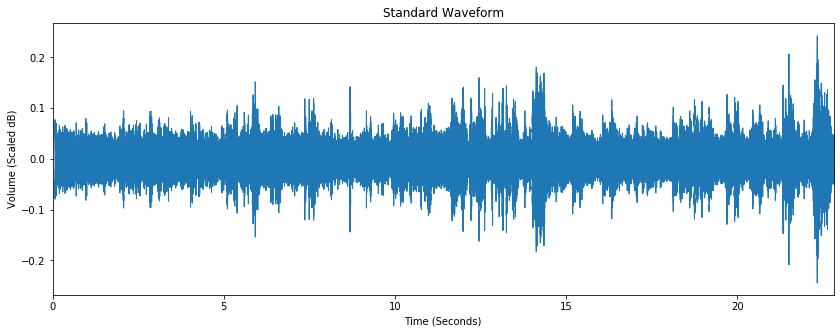

In [89]:
audiofile='./BlueJayCalls/BlueJayWAV/bluejay1.wav'
x , sr = librosa.load(audiofile)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Standard Waveform')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

The above is an example of a standard recording's waveform, wherein the energy output over time can be observed. As mentioned, obvious shortcoming of this feature is that the energy output is influenced by anything heard in the recording, not just the bird's call itself. For instance, the actual bird call in the pictured recording begins at about five seconds in (the first five seconds are white noise). This white noise can therefore affect the average energy root mean square value of the entire recording.

## Chroma Vector

Related to the overall energy output of a recording, the chroma vector categorizes a recording's energy output by pitch. In other words, it classifies over time how much of a recording's wave amplitude can be attributed to a given tone. As bird calls often follow the same tonal interval pattern, the chroma vector for specific bird calls becomes an invaluable gauge to differentiate one call from another.

Text(0.5, 1.0, 'Blue Jay Chroma Vector')

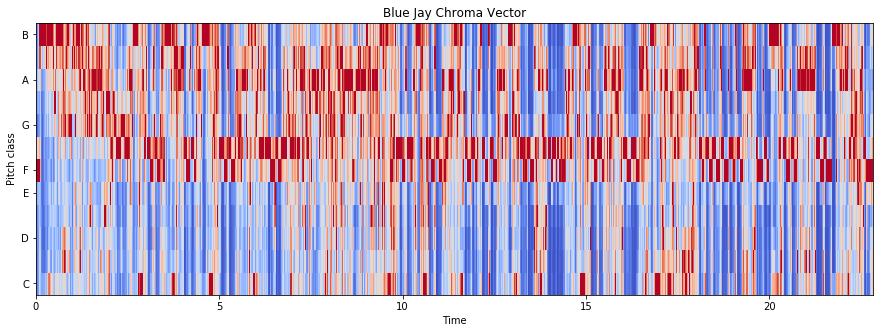

In [91]:
chromagram = librosa.feature.chroma_stft(x, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Blue Jay Chroma Vector')

As can be seen above, the blue jay's chroma vector indicates high presence of F and F# notes (on a conventional musical scale). The downside of this feature is that, with variation in individual birds' voiceboxes, pitch variation is also observed. However, enough pitch similarity exists within a species such that this gauge is still valuable in model construction.


## Spectral Centroid

Another gauge of pitch essentially, the spectral centroid of a recording finds the average frequency of a recording at a given point in time. However, this average frequency is weighted according to volume output. Altogether then, this gauge essentially calculates a sort of center of mass, in terms of frequency, for the bird calls. When averaged over the length of the recording, this gauge allows the model to compare the general frequency range at which each recording resides.

Text(0.5, 0, 'Time (Seconds)')

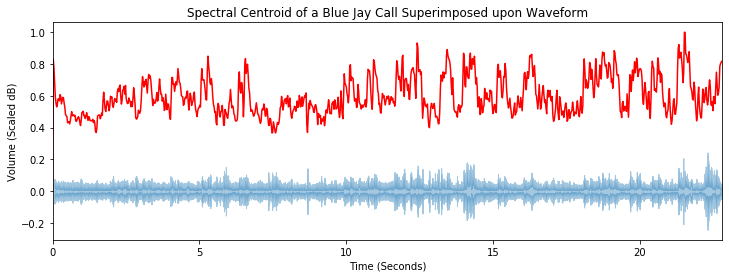

In [98]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.title('Spectral Centroid of a Blue Jay Call Superimposed upon Waveform')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

## Spectral Bandwidth

Spectral bandwidth measures, for a given point in a recording's time, the range of frequencies that are above a certain standard deviation threshhold of energy output. In other words, this essentially gauges a bird's instantaneous vocal range within a call and can help qualify the bird's tonal quality or character.

Seen below is the blue jay's spectral bandwidth superimposed upon a given call's standard waveform. Three different threshold standard deviations are displayed.

Text(0.5, 0, 'Time (Seconds)')

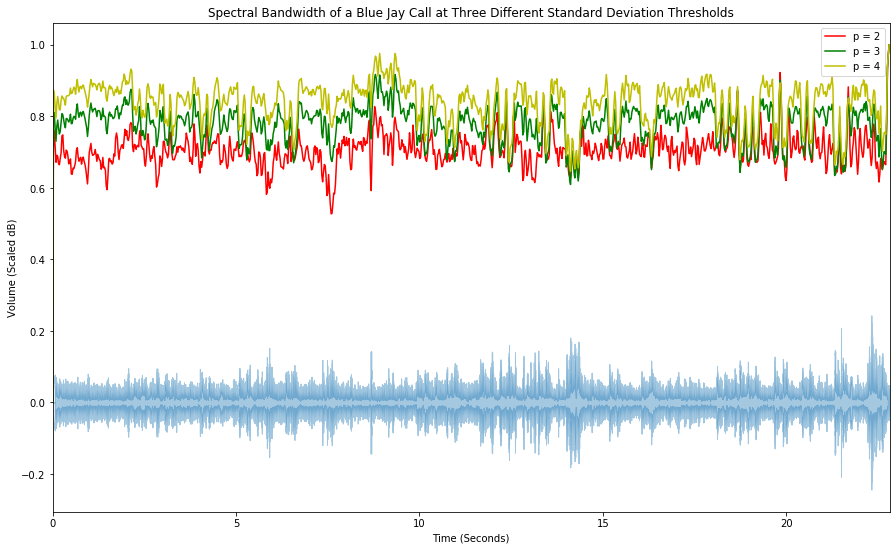

In [97]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
plt.title('Spectral Bandwidth of a Blue Jay Call at Three Different Standard Deviation Thresholds')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

## Spectral Rolloff

Spectral rolloff is related to bandwidth. However, as opposed to indexing the magnitude of the frequency range within which a recording exists, it records the upper bound of that range. In this way, this feature generally measures how high the bird's call is. The spectral rolloff for a blue jay call can be seen below.

Text(0.5, 0, 'Time (Seconds)')

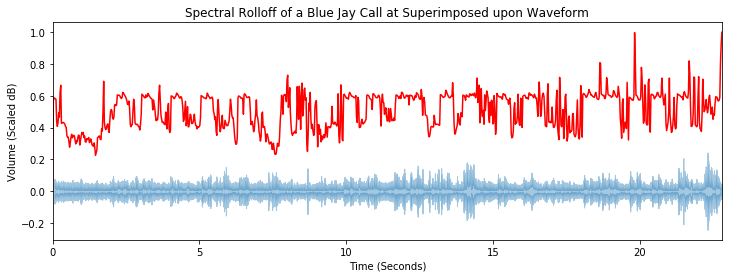

In [101]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.title('Spectral Rolloff of a Blue Jay Call at Superimposed upon Waveform')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

## Zero Crossing Rate

Zero crossing rate is another gauge to help analyze the tonal quality of a given bird's voice, specifically smoothness. In short, it measures the rate at which a recording's waveform oscillates from positive to negative decibel values. Below is a zoomed in version of the blue jay call's standard waveform, wherein these zero crossings are more easily seen.

Text(0.5, 0, 'Time (Seconds)')

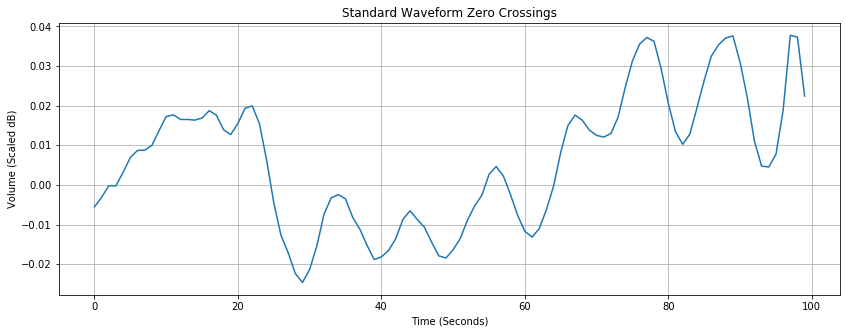

In [104]:
n0 = 8000
n1 = 8100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

plt.title('Standard Waveform Zero Crossings')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

All extracted audio samples are decomposed into the above six features. Features are averaged over the recording time.

With the salient features identified and piloted on example call samples, the rest of the data set is web scraped and manipulated in order to produce features out of these spectral characteristics for each individual sample.

First, all required packages for the notebook are imported.

In [3]:
# Import relevant Python packages
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import librosa
import pyaudio
import numpy as np
import wave
import scipy.io.wavfile as wavfile
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
try:
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import f1_score
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# Web scrape all finch calls from xeno-canto

rmss=[]
chroma_stfts=[]
spec_cents=[]
spec_bws=[]
rolloffs=[]
zcrs=[]
species=[]
load_bar=0

for finchclip in finchclips:
    load_bar+=1
    if finchclip=='.ipynb_checkpoints':
        continue
    filename='./FinchCalls/FinchWAV/'+finchclip
    y, sr = librosa.load(filename, mono=True)#, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Create features from finch audio spectral attributes     
    rmss.append(np.mean(rmse))
    chroma_stfts.append(np.mean(chroma_stft))
    spec_cents.append(np.mean(spec_cent))
    spec_bws.append(np.mean(spec_bw))
    rolloffs.append(np.mean(rolloff))
    zcrs.append(np.mean(zcr))
    species.append('Finch')
    print(str(load_bar)+' of '+str(len(finchclips)))

In [ ]:
# Web scrape all cardinal calls from xeno-canto

load_bar=0

for cardinalclip in cardinalclips:
    load_bar+=1
    if cardinalclip=='.ipynb_checkpoints':
        continue
    filename='./CardinalCalls/CardinalWAV/'+cardinalclip
    y, sr = librosa.load(filename, mono=True)#, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Create features from cardinal audio spectral attributes
    rmss.append(np.mean(rmse))
    chroma_stfts.append(np.mean(chroma_stft))
    spec_cents.append(np.mean(spec_cent))
    spec_bws.append(np.mean(spec_bw))
    rolloffs.append(np.mean(rolloff))
    zcrs.append(np.mean(zcr))
    species.append('Cardinal')
    print(str(load_bar)+' of '+str(len(cardinalclips)))

In [ ]:
# Web scrape all blue jay calls from xeno-canto

load_bar=0

for bluejayclip in bluejayclips:
    load_bar+=1
    if bluejayclip=='.ipynb_checkpoints':
        continue
    filename='./BlueJayCalls/BlueJayWAV/'+bluejayclip
    y, sr = librosa.load(filename, mono=True)#, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Create features from blue jay audio spectral attributes
    rmss.append(np.mean(rmse))
    chroma_stfts.append(np.mean(chroma_stft))
    spec_cents.append(np.mean(spec_cent))
    spec_bws.append(np.mean(spec_bw))
    rolloffs.append(np.mean(rolloff))
    zcrs.append(np.mean(zcr))
    species.append('BlueJay')
    print(str(load_bar)+' of '+str(len(bluejayclips)))

With the audio samples downloaded, all spectral features for each species are combined into a single dataframe, from which a model can be constructed.

In [ ]:
d = {'rmse': rmss, 
    'chroma': chroma_stfts, 
    'spectral_centroid': spec_cents, 
    'spectral_bandwidth': spec_bws,
    'rolloffs': rolloffs,
    'zero_crossing_rate': zcrs,
    'species':species}

df = pd.DataFrame(data=d)

The resulting dataframe can be seen below, which shows all relevant features to the left and, finally, the target variable (bird species) on the far right.

In [17]:
df.head()

,rmse,chroma,spectral_centroid,spectral_bandwidth,rolloffs,zero_crossing_rate,species
0,0.002708,0.513089,3057.324075,2541.607673,6256.695341,0.214290,Finch
1,0.057995,0.490443,3015.772026,2393.408499,5451.500054,0.211370,Finch
2,0.009865,0.562847,2319.632484,2131.946880,4320.741434,0.114888,Finch
3,0.003882,0.598745,1810.520794,1703.748637,3354.493978,0.118544,Finch
4,0.058251,0.338655,4433.939529,1775.263353,6015.796187,0.380245,Finch


To analyze the integrity of the sampled data, medians and standard devaitions of each characteristic for each bird species are found. The idea here is that, since each species of bird is relatively the same size, standard deviations between all characteristics should be similar. Since each bird call is different, though, median values for each characteristic should be substantively different.

First, median values are observed below:

In [18]:
df.groupby(by=['species']).median()

,rmse,chroma,spectral_centroid,spectral_bandwidth,rolloffs,zero_crossing_rate
species,,,,,,
BlueJay,0.017670,0.507135,3211.080540,2307.193696,5730.498275,0.223060
Cardinal,0.017843,0.476414,3334.230929,2283.895942,5650.179716,0.231455
Finch,0.018401,0.487858,3674.125977,2246.272976,5887.324374,0.276619


The data science team observes meaningful differences in feature medians, which should lead to substantive differentiation of the model from species to species. For example, the spectral_centroid feature median differs by ~14% from blue jay to finch; other features exhibit similar differences. Therefore, the manipulated features provide valuable insight into audio samples and their respective species.

Next, standard devaitions are observed below:

In [19]:
df.groupby(by=['species']).std()

,rmse,chroma,spectral_centroid,spectral_bandwidth,rolloffs,zero_crossing_rate
species,,,,,,
BlueJay,0.025849,0.107857,1188.081868,378.035998,1688.287974,0.129551
Cardinal,0.026043,0.101492,1122.062078,388.233724,1574.327289,0.123872
Finch,0.027228,0.098117,1082.697905,374.294547,1467.236423,0.121857


Standard deviations also show substantive differences. In the case of the spectral_centroid feature, standard deviations differ by ~10% for all species. In an ideal scenario, all standard devaitions, again, would be more similar. This difference indicates a possible lack of integrity in sampled audio, likely caused by white noise. The data science team notes this discrepancy and recognizes it as a possible area for improvement after subsequent model development.

Visual representation of features with largest standard deviation differences is seen below to help illustrate these discrepancies:

Text(0.5, 1.0, 'Standard Deviations of Spectral Centroids')

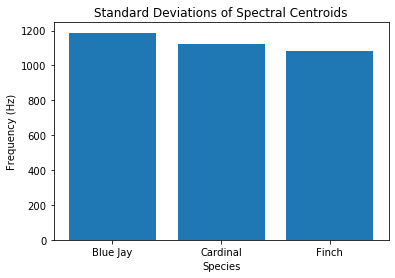

In [20]:
# Display standard deviation values for spectral centroids
stds=df.groupby(by=['species']).std()
y=list(stds.spectral_centroid)
plt.bar(['Blue Jay', 'Cardinal', 'Finch'], y)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Species')
plt.title('Standard Deviations of Spectral Centroids')

Text(0.5, 1.0, 'Standard Deviations of Rolloffs')

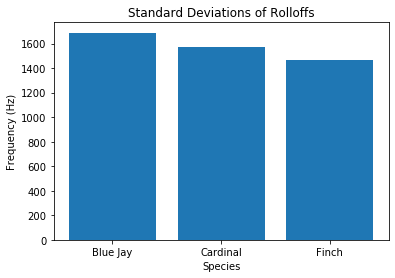

In [21]:
# Display standard deviation values for spectral rolloffs
stds=df.groupby(by=['species']).std()
y=list(stds.rolloffs)
plt.bar(['Blue Jay', 'Cardinal', 'Finch'], y)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Species')
plt.title('Standard Deviations of Rolloffs')

# Model Fitting and Interpretation

## Train Test Split

For model creation, the data science team uses the constructed dataframe to create training and testing partitions. Bird species is defined as the model target, whereas all other six audio characteristics are defined as model features.

In [8]:
df=pd.read_csv('bird_csv-Copy1')
df=df.drop(columns=['Unnamed: 0'])
df.head()

,rmse,chroma,spectral_centroid,spectral_bandwidth,rolloffs,zero_crossing_rate,species
0,0.002708,0.513089,3057.324075,2541.607673,6256.695341,0.214290,Finch
1,0.057995,0.490443,3015.772026,2393.408499,5451.500054,0.211370,Finch
2,0.009865,0.562847,2319.632484,2131.946880,4320.741434,0.114888,Finch
3,0.003882,0.598745,1810.520794,1703.748637,3354.493978,0.118544,Finch
4,0.058251,0.338655,4433.939529,1775.263353,6015.796187,0.380245,Finch


In [9]:
# Establish features and target in data
features=df.drop(['species'], axis=1)
target=df.species

encoder = LabelEncoder()
y = encoder.fit_transform(target)

# Split features and target into training and testing partitions
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=1)

# Scale feature set according to standard distribution to make results more interpretable
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

## Decision Tree Model

A decision tree model is first developed. Using training data, the model is first fine tuned using a grid search with wide parameter ranges in order to help determine best performing values for hyperparameters. The model is fine tuned three times in order to dial in on exact, best performing hyperparameter values.

F1-score is used as a basis off of which to gauge tuning. F1-score is ultimately used, as well, as the model's metric for success. Since the model is multi-class and since some class imbalance is present (cardinal audio samples account for over 45% share of the dataset), F1-score will provide a better gauge of model performance than pure accuracy (since a blind model could theoretically, then, achieve 45% accuracy by always predicting the cardinal majority species class).

In [ ]:
param_grid = {
    'max_depth': list(range(1,20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.4, 0.8],
    'min_impurity_split': [0, 0.4, 0.8]
    }

# Grid search is executed with F1 as scoring method

grid_dt=GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_dt.fit(X_train, y_train)

grid_dt.best_params_

First iteration of grid search is completed above. A second iteration is performed below, wherein hyperparameter ranges are tightened.

In [ ]:
param_grid = {
    'max_depth': list(range(1,20)),
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [1, 2, 3],
    'min_weight_fraction_leaf': [0, 0.05, 0.1],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.05, 0.1],
    'min_impurity_split': [0, 0.05, 0.1]
    }

# Grid search is executed with F1 as scoring method

grid_dt=GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_dt.fit(X_train, y_train)

grid_dt.best_params_

A third iteration is performed below, wherein hyperparameter ranges are tightened.

In [ ]:
param_grid = {
    'max_depth': [9.5, 10, 10.5],
    'min_samples_split': [8, 9, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3],
    'min_weight_fraction_leaf': [0, 0.01, 0.02],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.05, 0.1],
    'min_impurity_split': [0, 0.05, 0.1]
    }

# Grid search is executed with F1 as scoring method

grid_dt=GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_dt.fit(X_train, y_train)

grid_dt.best_params_

With the final hyperparameters determined, the model is created and evaluated, based on F1-score, below.

In [7]:
# Initiate decision tree model
dtc = DecisionTreeClassifier(criterion= 'gini', 
                             max_depth=10, 
                             max_features='auto', 
                             min_impurity_decrease=0, 
                             min_impurity_split=0, 
                             min_samples_leaf=1, 
                             min_samples_split=11, 
                             min_weight_fraction_leaf=0, 
                             class_weight='balanced', 
                             random_state=1)

# Fit model to training data
dtc.fit(X_train, y_train)

# Use model to predict test set's target species
dtc_preds  = dtc.predict(X_test)

# Evaluate F1-score of predictions
f1_score(y_test, dtc_preds, average='weighted')

0.44443982694207596

The resulting model produces an F1-score of ~0.44, which definitely leaves room for improvement. As the decision tree model is relatively simple, this base F1-score will serve as a benchmark for comparison for subsequent, more complicated models.

With the resulting decision tree, the feature importance of each spectral characteristic is calculated.

In [41]:
# Calculate feature importance
feat_importance = dtc.tree_.compute_feature_importances(normalize=False)

# Display feature importance
for index in range(0, len(feat_importance)):
    print(df.columns[index]+': '+str(feat_importance[index]))

rmse: 0.0449619574847499
chroma: 0.05434698539474408
spectral_centroid: 0.06418362081885344
spectral_bandwidth: 0.04894831084464352
rolloffs: 0.05629929660252594
zero_crossing_rate: 0.03197610532092529


As can be seen, spectral centroid of the recording is the most important feature to differentiate target species from one another. For future improvement, least important features (namely zero crossing rate), could stand to be culled and massaged in order to boost model performance.

## Random Forest Model

A random forest model is next developed, as it is essentially a more complex version of a decision tree in that it's based off of the combined predictive results of multiple decision tree models.

F1-score is again used as a success metric (for the same reasons as above). The model is similarly tuned three times in order to zero in on hyperparameter values that lend themselves to optimal performance.

In [12]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1,20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.4, 0.8],
    'min_impurity_split': [0, 0.4, 0.8],
    'bootstrap': [True, False]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

First iteration of grid search is completed above. A second iteration is performed below, wherein hyperparameter ranges are tightened.

In [ ]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini'],
    'max_depth': [10, 11, 12, 13, 14, 15],
    'min_samples_split': [1.0, 2, 3, 4],
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'min_weight_fraction_leaf': [0, 0.1, 0.2],
    'max_features': ['auto'],
    'min_impurity_decrease': [0, 0.1, 0.2],
    'min_impurity_split': [0, 0.1, 0.2],
    'bootstrap': [False]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

A third iteration is performed below, wherein hyperparameter ranges are tightened.

In [ ]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini'],
    'max_depth': [13],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'min_weight_fraction_leaf': [0],
    'max_features': ['auto'],
    'min_impurity_decrease': [0, 0.01, 0.02],
    'min_impurity_split': [0.08, 0.09, 0.1, 0.11, .12],
    'bootstrap': [False]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

Due to processing power (and therefore time) required to also grid search number of trees in the random forest model, n_estimator hyperparameter tuned separately. First iteration of tuning this hyperparameter below:

In [13]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini'],
    'max_depth': [13],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'min_weight_fraction_leaf': [0],
    'max_features': ['auto'],
    'min_impurity_decrease': [0],
    'min_impurity_split': [0.1],
    'bootstrap': [False],
    'n_estimators': [10, 50, 100, 500]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.1s finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'auto',
 'min_impurity_decrease': 0,
 'min_impurity_split': 0.1,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 500}

In [14]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini'],
    'max_depth': [13],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'min_weight_fraction_leaf': [0],
    'max_features': ['auto'],
    'min_impurity_decrease': [0],
    'min_impurity_split': [0.1],
    'bootstrap': [False],
    'n_estimators': [400, 500, 1000, 5000]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'auto',
 'min_impurity_decrease': 0,
 'min_impurity_split': 0.1,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 500}

In [15]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini'],
    'max_depth': [13],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'min_weight_fraction_leaf': [0],
    'max_features': ['auto'],
    'min_impurity_decrease': [0],
    'min_impurity_split': [0.1],
    'bootstrap': [False],
    'n_estimators': [450, 475, 500, 550, 575]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.0min finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'auto',
 'min_impurity_decrease': 0,
 'min_impurity_split': 0.1,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 500}

With the final hyperparameters determined, the model is created and evaluated, based on F1-score, below.

In [16]:
# Establish random forest model

rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                              criterion='gini', max_depth=13,
                                              max_features='auto',
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=0.1,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0,
                                              n_estimators=500,
                                              random_state=1)

# Fit random forest model to training data
rfc.fit(X_train, y_train)

# Make predictions on test set with model
rfc_preds  = rfc.predict(X_test)

# Evaluate each model based on F1-score, and display accuracy just for reference

f1_score(y_test, rfc_preds, average='weighted')

0.47171681628114853

The data science team observes a slight improvement over the simple decision tree model with the random forest's F1-score of ~0.45. This improvement, however, is only incremental. The team again finds feature importance within the model to determine possible areas of improvement for the features themselves.

In [46]:
# Calculate feature importance
feat_importance = rfc.feature_importances_

# Display feature importance
for index in range(0, len(feat_importance)):
    print(df.columns[index]+': '+str(feat_importance[index]))

rmse: 0.12998822779687
chroma: 0.17504205424277985
spectral_centroid: 0.20368445730693954
spectral_bandwidth: 0.15909944982288876
rolloffs: 0.17217549031058343
zero_crossing_rate: 0.16001032051993838


The random forest feature importance further solidifies conclusions drawn from the simple decision tree model. Overall, spectral bandwidtch and zero crossing rate appear to be the features that lend least clout to the predictive abilities of the model and should be massaged in further analysis to boost performance.

## Support-vector Machine Model

To diversify the model set, a support-vector machine model is developed.

F1-score is again used as a success metric (for the same reasons as above). The model is similarly tuned three times in order to zero in on hyperparameter values that lend themselves to optimal performance.

In [67]:
# Random forest parameters are set up to be evaluated

param_grid = {'kernel': ['linear', 'rbf', 'poly'],
               'gamma': ['auto', 'scale'],
               'C': [0.1, 1, 10, 100],
               'degree':[0, 1, 2, 3, 4, 5],
               'shrinking': [True, False],
               'class_weight': ['balanced', None]
              
    }

# Grid search is executed with F1 as scoring method

grid_SVM=GridSearchCV(SVC(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_SVM.fit(X_train, y_train)
grid_SVM.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 2312 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2762 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  8.9min finished


{'C': 100,
 'class_weight': None,
 'degree': 0,
 'gamma': 'scale',
 'kernel': 'rbf',
 'shrinking': False}

First iteration of grid search is completed above. A second iteration is performed below, wherein hyperparameter ranges are tightened.

In [70]:
# Random forest parameters are set up to be evaluated

param_grid = {'kernel': ['rbf'],
               'gamma': ['scale'],
               'C': [100, 1000, 10000],
               'degree':[0],
               'shrinking': [False],
               'class_weight': [ None]
              
    }

# Grid search is executed with F1 as scoring method

grid_SVM=GridSearchCV(SVC(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_SVM.fit(X_train, y_train)
grid_SVM.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   14.3s finished


{'C': 1000,
 'class_weight': None,
 'degree': 0,
 'gamma': 'scale',
 'kernel': 'rbf',
 'shrinking': False}

A third iteration is performed below, wherein hyperparameter ranges are tightened.

In [71]:
# Random forest parameters are set up to be evaluated

param_grid = {'kernel': ['rbf'],
               'gamma': ['scale'],
               'C': [500, 1000, 5000],
               'degree':[0],
               'shrinking': [False],
               'class_weight': [ None]
              
    }

# Grid search is executed with F1 as scoring method

grid_SVM=GridSearchCV(SVC(random_state=1), param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_SVM.fit(X_train, y_train)
grid_SVM.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.4s finished


{'C': 500,
 'class_weight': None,
 'degree': 0,
 'gamma': 'scale',
 'kernel': 'rbf',
 'shrinking': False}

In [17]:
# Establish random forest model
from sklearn.svm import SVC

svm = SVC(kernel='rbf',
          gamma='scale',
          C=500,
          degree=0,
          shrinking=False,
          class_weight=None,
          probability=True,
          random_state=1)

# Fit random forest model to training data
svm.fit(X_train, y_train)

# Make predictions on test set with model
svm_preds  = svm.predict(X_test)

# Evaluate each model based on F1-score, and display accuracy just for reference

f1_score(y_test, svm_preds, average='weighted')

0.48435903725958973

The SVM model performs the best out of any of the previous models, improving overall F1-score to ~0.48. Again, though, this still is a relatively low F1-score, indicating possibility for improvement in the model overall.

## Random Forest and SVM Ensemble Model

Lastly, the data science team tests to see whether the combinatorial power of both the random forest and SVM models achieves any increase in overall performance.

Two ensemble models are thus created, with soft and hard voting respectively, and are gauged in terms of F1-score, again.

In [18]:
# Create two ensemble models with soft and hard voting, respectively
vc1 = VotingClassifier(
                estimators=[('svc', svm), ('randomforest', rfc)], 
                voting='soft')

vc2 = VotingClassifier(
                estimators=[('svc', svm), ('randomforest', rfc)], 
                voting='hard')

# Fit each model to the training data

vc1.fit(X_train, y_train)
vc2.fit(X_train, y_train)


# Create bankruptcy predictions with each model

vc1_preds = vc1.predict(X_test)
vc2_preds = vc2.predict(X_test)

# Evaluate F1 scores for both ensemble models

vc1_f1=f1_score(y_test, vc1_preds, average='weighted')
vc2_f1=f1_score(y_test, vc2_preds, average='weighted')

print(vc1_f1, vc2_f1)

0.4150068057825425 0.4881142605546533


The hard-voting ensemble model narrowly outperforms the SVM model.

Overall then, the team sees that the best performing model is the hard-voting ensemble model, which obtains an F1-score of ~0.49. As seen in below, the team can delve into and quantify any of the model's miscategorization with a confusion matrix. Essentially, this matrix allows visibility into exactly how many correct predictions were made for each class and, if incorrect predictions were made, what exactly their nature was.

In general, the confusion matrix shows low reliability of the predictions. For the majority cardinal target class, predictions had the highest rate of correctness, with ~70% of all cardinal predictions correct. However, gold finch predictions showed a much lower rate of correctness, with only around 14% of all predicted finch classes being correct.

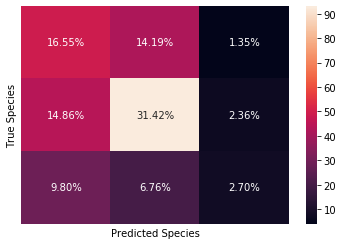

In [20]:
# Create SVM confusion matrix
cf_matrix=confusion_matrix(y_test, vc2_preds)

# Display percentages for each prediction type for all classes
label_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = np.asarray(label_percentages).reshape(3,3)

# Display heat map
sns.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=False, yticklabels=False)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")

# Conclusion and Next Steps

Overall the team finds that the hard-voting ensemble of random forest and SVM models performs best, with an F1-score of ~0.49. However, this indicative of relatively poor performance, seeing as the percent share of the majority class species is around 0.49, so a blind, majority-class-predicting model could theoretically perform on par.

The reason for poor performance is surmised to be overall integrity of sample recordings, as recognized during EDA. Standard devaitions of rolloffs and spectral centroids differed by around 15% and 10% between species, respectively. As these birds are all similarly sized, these differences should not be as high.

To eliminate these differences, the team needs to cull the sampled recordings to a fewer amount of more representative audio files. Ideally, these recordings should limit extra white noise and should contain purely the target bird's call.